In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

C:\Users\U0139040\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

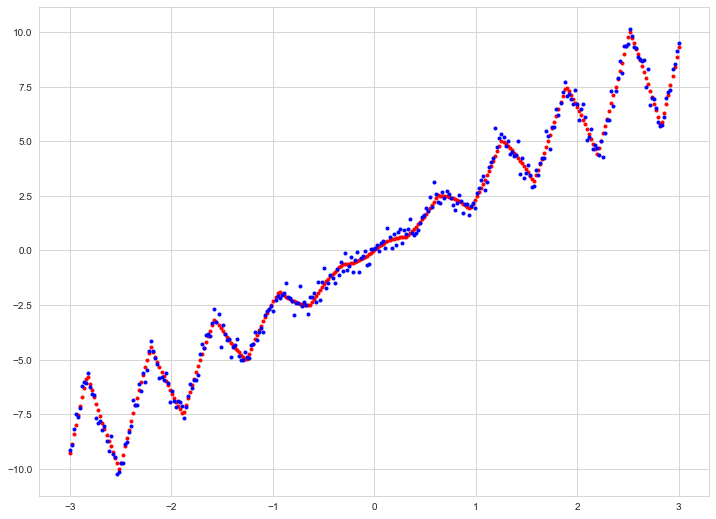

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать

def f(X):
    return (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X

np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = f(X)
plt.plot(X.reshape(-1), y.reshape(-1), "b.", color="red")
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.", color="blue");


In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$", label=r"$\hat{y}$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=label)


Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

max_depth=1 depth=1
max_depth=2 depth=2
max_depth=3 depth=3
max_depth=4 depth=4
max_depth=5 depth=5
max_depth=6 depth=6
max_depth=7 depth=7
max_depth=8 depth=8
max_depth=9 depth=9
max_depth=10 depth=10
max_depth=11 depth=11
max_depth=12 depth=12
max_depth=13 depth=13
max_depth=14 depth=13
max_depth=15 depth=13


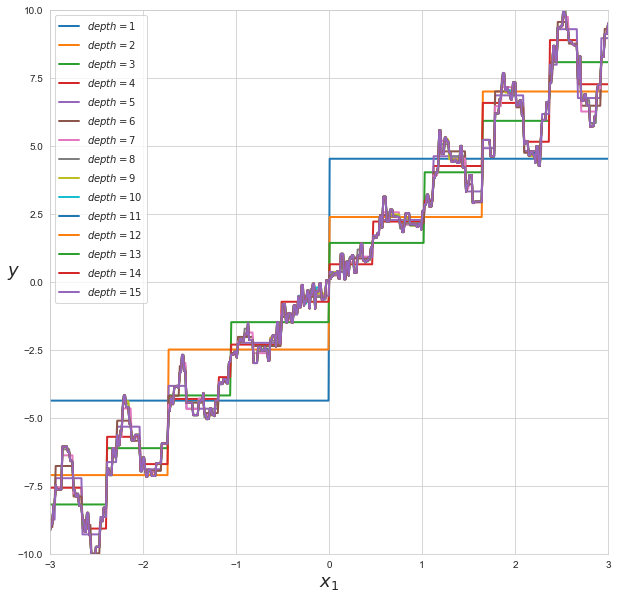

In [6]:
plt.figure(figsize=(10, 10))

for i in range(1, 16):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    clf_reg = DecisionTreeRegressor(max_depth=i, random_state=42)
    clf_reg.fit(X_train, y_train)
    print(f"max_depth={i} depth={clf_reg.get_depth()}")
    plot_regression_predictions(clf_reg, X, y, label=f"$depth={i}$")

plt.legend()
plt.show()

тут конечно ясно, что маленькие глубины дают плохие результаты, можно отбросить их, чтобы не загромождать график. также мы видим, что эффективная глубина дерева равна 13 даже при max_depth>=14.

max_depth=6 depth=6
max_depth=7 depth=7
max_depth=8 depth=8
max_depth=9 depth=9
max_depth=10 depth=10
max_depth=11 depth=11
max_depth=12 depth=12
max_depth=13 depth=13


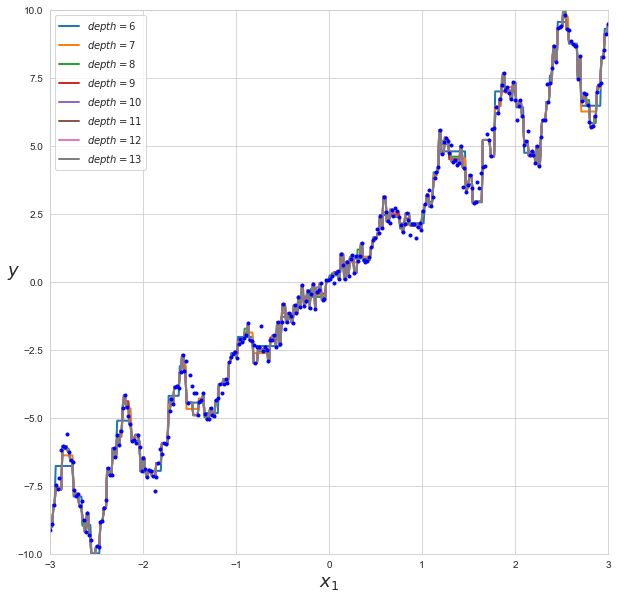

In [7]:
plt.figure(figsize=(10, 10))

for i in range(6, 14):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    clf_reg = DecisionTreeRegressor(max_depth=i, random_state=42)
    clf_reg.fit(X_train, y_train)
    print(f"max_depth={i} depth={clf_reg.get_depth()}")
    plot_regression_predictions(clf_reg, X, y, label=f"$depth={i}$")

plt.legend()
plt.plot(X.reshape(-1), y.reshape(-1), "b.", color="blue");
plt.show()

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [8]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

пусть у нас есть три классификатора, которые с вероятностью p предсказывают класс объекта правильно.
с какой вероятностью такой ансамбль предскажет класс объекта правильно? важно: majority votes:
 ```mu = p*p*p + p*p*(1-p) * 3```

если обобщить по индукции, то получим как раз формулу выше.



In [9]:
def ensemble_proba(p, n):
    size = int(np.floor(n/2+1))
    mu = 0.0
    for i in range(size, n+1):
        mu += math.comb(n, i) * math.pow(p, i) * math.pow(1 - p, n - i)
    return mu

In [10]:
ensemble_proba(p=0.7, n=3)

0.7839999999999999

ensemble_proba_p(0.6)=0.979


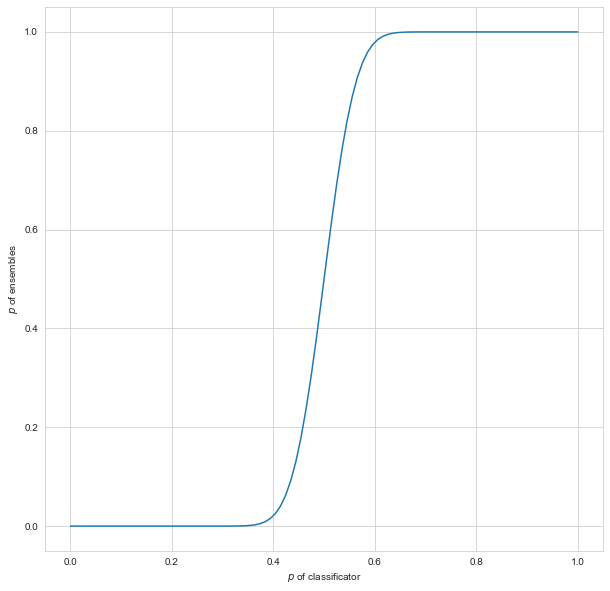

In [11]:
def ensemble_proba_p(p, n=101):
    return ensemble_proba(p, n)

plt.figure(figsize=(10, 10))
x = np.linspace(0.0, 1.0, num=100)
y = np.array(list(map(ensemble_proba_p, x)))
plt.xlabel("$p$ of classificator")
plt.ylabel("$p$ of ensembles")
print(f"ensemble_proba_p(0.6)={ensemble_proba_p(0.6):.3f}")
plt.plot(x, y);

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [12]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

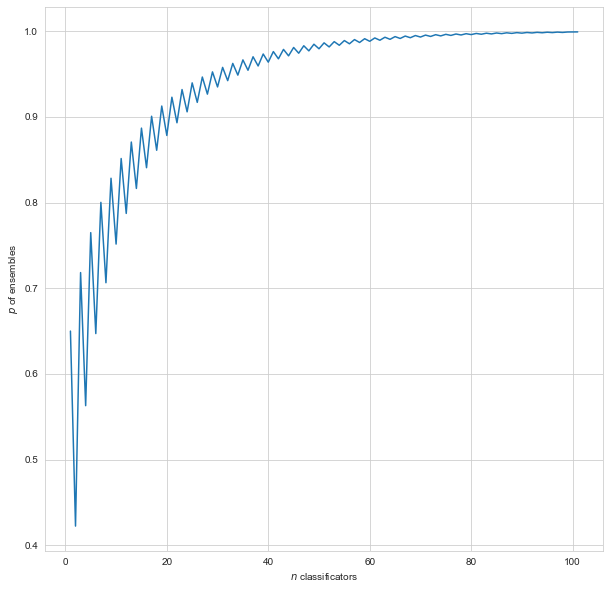

In [13]:
def ensemble_proba_n(n, p=0.65):
    return ensemble_proba(p, n)

plt.figure(figsize=(10, 10))
x = np.linspace(1, 101, num=100, dtype=np.int)
y = np.array(list(map(ensemble_proba_n, x)))
plt.xlabel("$n$ classificators")
plt.ylabel("$p$ of ensembles")
plt.plot(x, y);

Опишите ваши наблюдения:

* если мы возьмём классификатор с p=0.6, то ансамбль из сотни таких классификаторов предсказывает класс c вероятностью 0.98. то есть ансамбль слабых классификаторов является хорошей моделью. или мы можем сказать, что имею классификатор с p=0.6 нам потребуется ансамбль из сотни классификаторов, чтобы получить хорошую модель.
* сколько классификаторов с p=0.65 нужно взять в ансамбль, чтобы вероятность предсказать модель была 0.97?   ответ: 40.  Любопытно, что зависимость оказалась пилообразной, хотя с увеличением размера ансамбля это поведение становится несущественным.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [14]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            feat_ids_sample = np.random.choice(np.arange(X.shape[1]), self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids_sample)
            indices_sample = np.random.choice(np.arange(X.shape[0]), X.shape[0], replace=True)

            clf = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features)
            X_to_fit = X[:, feat_ids_sample][indices_sample]
            if len(feat_ids_sample) == 1:
                X_to_fit = X_to_fit.reshape(-1, 1)

            clf.fit(X_to_fit, y[indices_sample])
            self.trees.append(clf)
        return self

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

        proba = np.zeros((X.shape[0], len(self.classes_)))
        for clf, clf_features in zip(self.trees, self.feat_ids_by_tree):
            proba += clf.predict_proba(X[:, clf_features])
        return proba / self.n_estimators
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [15]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=10)
    plt.ylabel(r"$x_2$", fontsize=10, rotation=0)

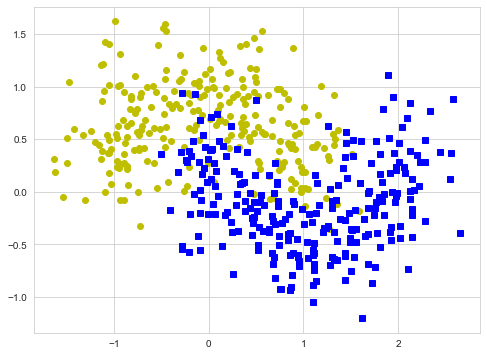

In [16]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)
plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show();

In [17]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

попробуем наш классификатор с разными гиперпараметрами, и будем сравнивать его с библиотечным RandomForestClassifier:
- нарисуем графики с разделяющей границей
- слева будет RandomForestClassifierCustom, справа - RandomForestClassifier
- имя классификатора "Custom10-d10-f1" - RandomForestClassifierCustom, из 10 деревьев, глубиной 10 и одной фичей.
- и для каждого посчитаем _MSE_


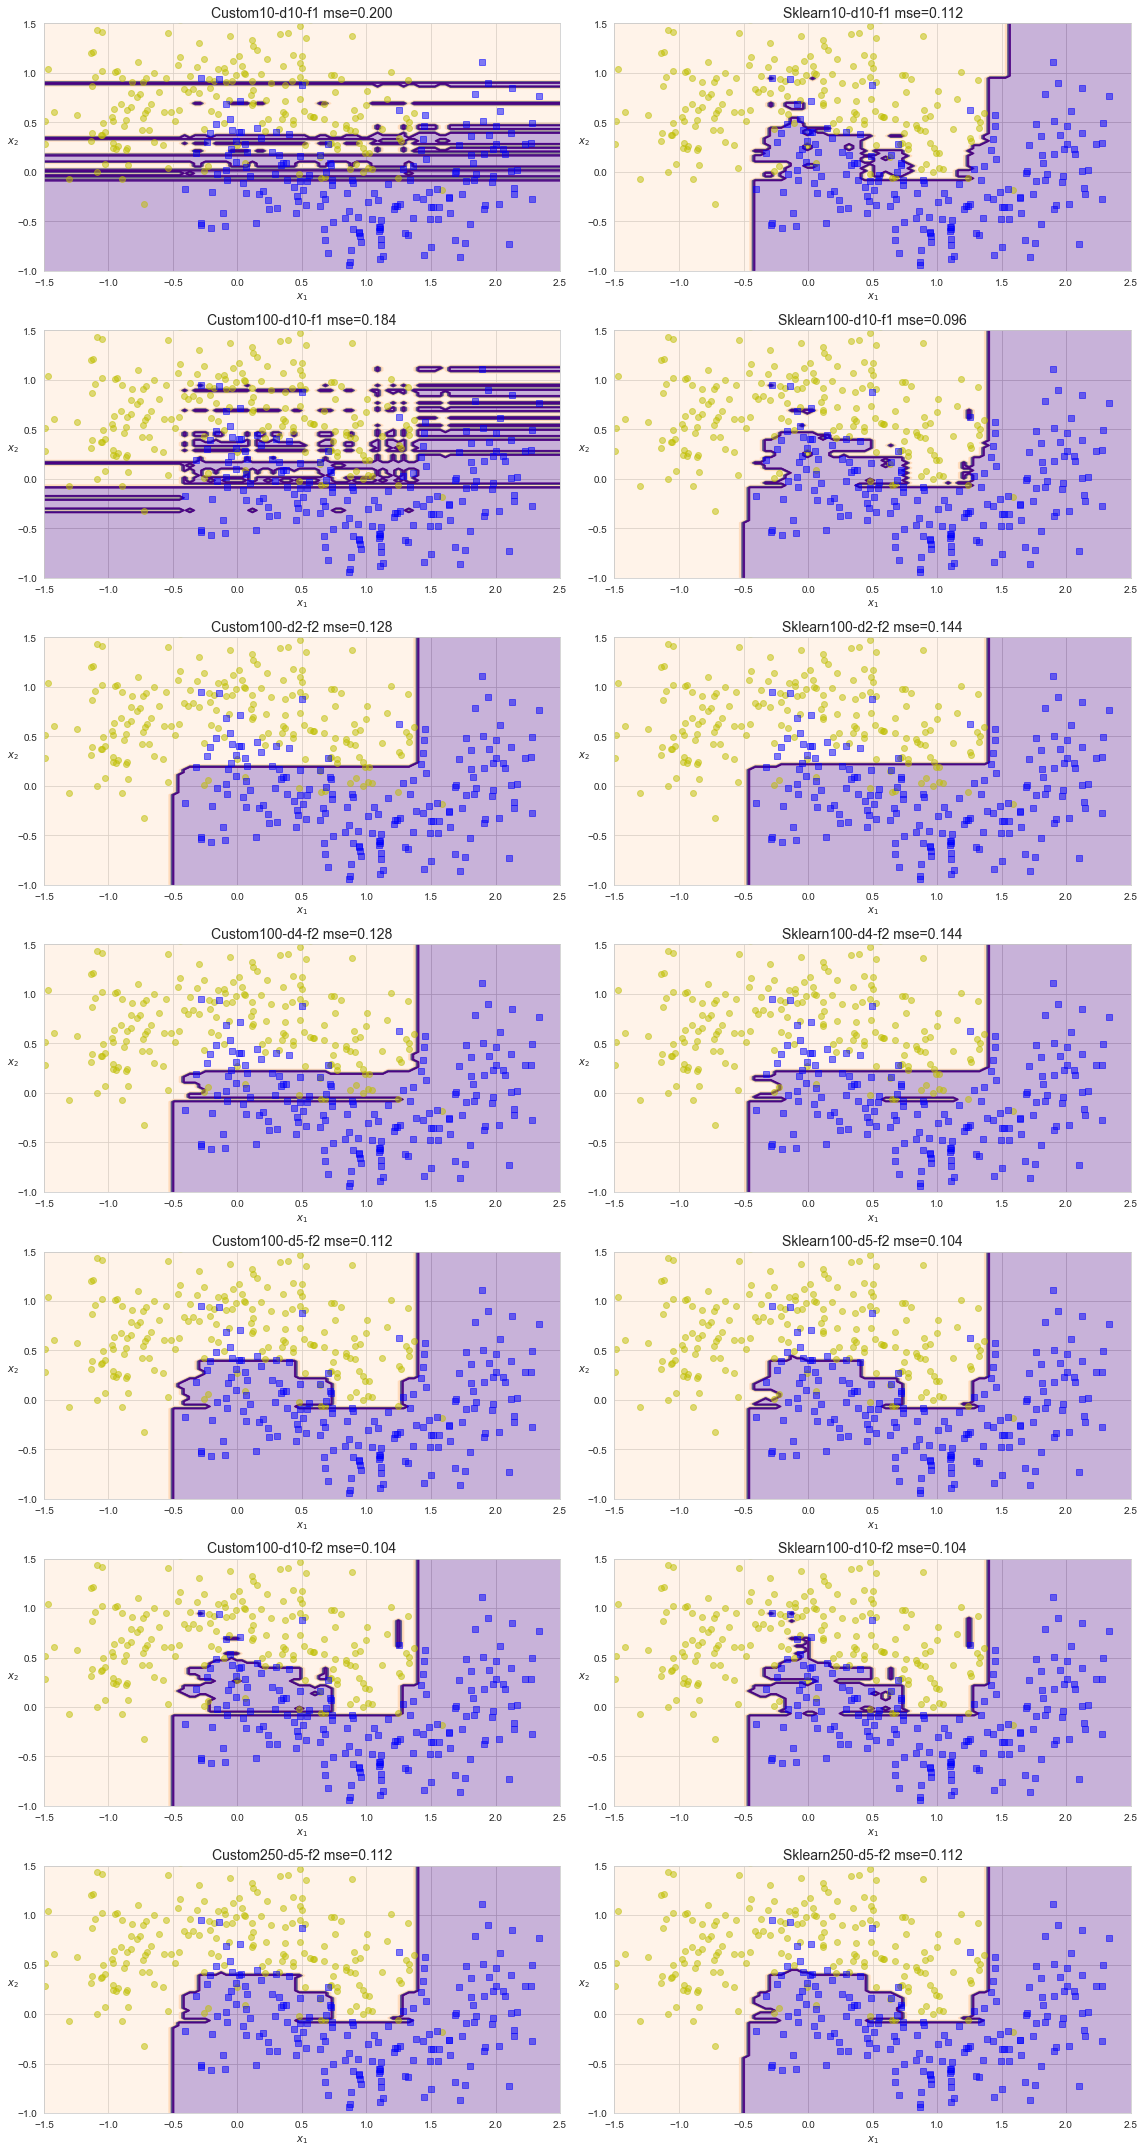

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clfs = {
    "Custom10-d10-f1": RandomForestClassifierCustom(n_estimators=10, max_depth=10, max_features=1, random_state=42),
    "Sklearn10-d10-f1": RandomForestClassifier(n_estimators=10, max_depth=10,  max_features=1, random_state = 42, n_jobs=-1),

    "Custom100-d10-f1": RandomForestClassifierCustom(n_estimators=100, max_depth=10, max_features=1, random_state=42),
    "Sklearn100-d10-f1": RandomForestClassifier(n_estimators=100, max_depth=10,  max_features=1, random_state = 42, n_jobs=-1),

    "Custom100-d2-f2": RandomForestClassifierCustom(n_estimators=100, max_depth=2, max_features=2, random_state=42),
    "Sklearn100-d2-f2": RandomForestClassifier(n_estimators=100, max_depth=2,  max_features=2, random_state = 42, n_jobs=-1),

    "Custom100-d4-f2": RandomForestClassifierCustom(n_estimators=100, max_depth=4, max_features=2, random_state=42),
    "Sklearn100-d4-f2": RandomForestClassifier(n_estimators=100, max_depth=4,  max_features=2, random_state = 42, n_jobs=-1),

    "Custom100-d5-f2": RandomForestClassifierCustom(n_estimators=100, max_depth=5, max_features=2, random_state=42),
    "Sklearn100-d5-f2": RandomForestClassifier(n_estimators=100, max_depth=5,  max_features=2, random_state = 42, n_jobs=-1),

    "Custom100-d10-f2": RandomForestClassifierCustom(n_estimators=100, max_depth=10, max_features=2, random_state=42),
    "Sklearn100-d10-f2": RandomForestClassifier(n_estimators=100, max_depth=10,  max_features=2, random_state = 42, n_jobs=-1),

    "Custom250-d5-f2": RandomForestClassifierCustom(n_estimators=250, max_depth=5, max_features=2, random_state=42),
    "Sklearn250-d5-f2": RandomForestClassifier(n_estimators=250, max_depth=5,  max_features=2, random_state = 42, n_jobs=-1)
}

for name, clf in clfs.items():
    clf.fit(X_train, y_train)

plt.figure(figsize=(16, 30))
for idx, (name, clf) in enumerate(clfs.items()):
    plt.subplot(len(clfs)//2, 2, idx + 1)
    plot_decision_boundary(clf, X_train, y_train)

    mse = mean_squared_error(y_test, clf.predict(X_test))
    plt.title(f"{name} mse={mse:.3f}", fontsize=14)
plt.tight_layout()
plt.subplots_adjust()
plt.show()

Что мы получили?
1. в целом библиотечный RandomForestClassifier лучше нашего
   - это видно и по MSE (хотя Custom100-d10-f2 работает с такой же ошибкой как и Sklearn100-d10-f2) и визуально по разделяющей границе.
2. почему-то наш классификатор особенно плох при ```max_features=1```. по сути, он переобучился, нарезав  X2 на маленькие отрезки и захватив выбросы синих точек из третьего квадранта. ВАЖНО: при ```n_estimators=100``` переобучение уже не так велико и _MSE_ уменьшилась с 0.272 до 0.176, но всё же заметно больше, чем у RandomForestClassifier. ошибка в коде?
3. RandomForestClassifierCustom при глубине 10 предсказывает так же как и при глубине 5 (то же для RandomForestClassifier).

затем я попробовала еще два случая:
- глубину 4: Custom100-d4-f2 и Sklearn100-d4-f2, она оказалась чуть хуже depth=5
- Custom250-d5-f2 + Sklearn250-d5-f2: почему-то библиотечный лес выдал _MSE=0.112_, при том что для 100 деревьев он давал _MSE=0.104_, то есть меньшую ошибку. хотелось бы понять почему?

4. тем не менее мы знаем, что depth=5 дает минимальную ошибку MSE.

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [19]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

предыдущий пункт уже частично отвечает на вопрос: мы знаем оптимальные глубину (5) и max_features (2).
в том числе, кажется что n_estimators=100 дает хорошие результаты.
Для более тонкой подборки параметров стоит использовать GridSearchCV

мы уже знаем, что глубина 5 - это оптимальная глубина с точки зрения минимизации ошибки.
сравним обычное дерево глубиной 10 и наш лес глубиной 10.
мы ожидаем, что DT переобучит модель, а RF породит хорошую модель, с меньшим variance:


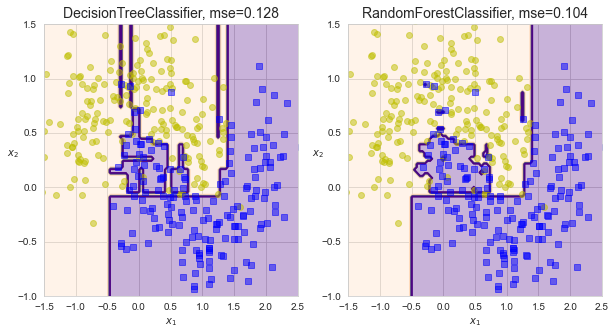

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf1 = DecisionTreeClassifier(max_depth=10, random_state=42)
clf1.fit(X_train, y_train)
mse1 = mean_squared_error(y_test, clf1.predict(X_test))

clf2 = RandomForestClassifierCustom(n_estimators=100, max_depth=10,  max_features=2, random_state = 42)
clf2.fit(X_train, y_train)
mse2 = mean_squared_error(y_test, clf2.predict(X_test))

plt.figure(figsize=(10, 5))
plt.subplot(121)
plot_decision_boundary(clf1, X_train, y_train)
plt.title(f"DecisionTreeClassifier, mse={mse1:.3f}", fontsize=14)
plt.subplot(122)
plot_decision_boundary(clf2, X_train, y_train)
plt.title(f"RandomForestClassifier, mse={mse2:.3f}", fontsize=14)
plt.show()

ну естественно так и вышло: RF не переобучается.

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [21]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [22]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [23]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [24]:
print(f"X has {X.shape[1]} features")

X has 30 features


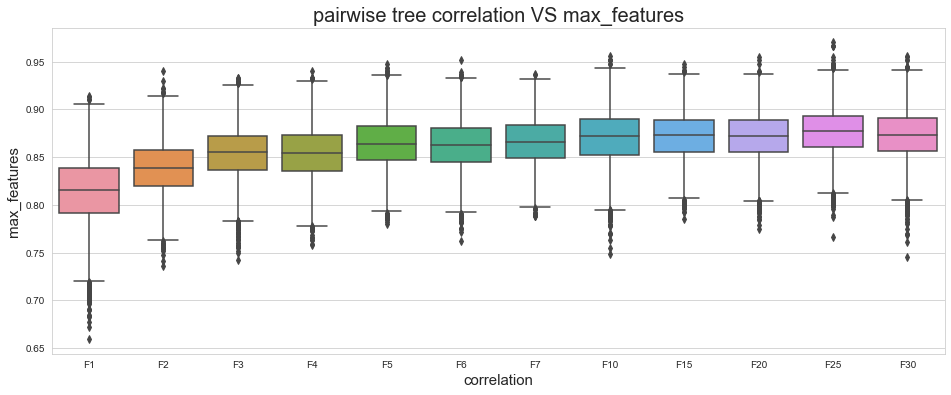

In [25]:
plt.figure(figsize=(16,6))
x_plot = []
y_plot = []

for max_features in [1, 2, 3, 4, 5, 6, 7, 10, 15, 20, 25, 30]:
    clf = RandomForestClassifier(n_estimators=100, max_features=max_features, random_state = 42)
    clf.fit(X_train, y_train)
    corr = base_model_pair_correlation(clf, X)
    y_plot.append(corr)
    x_plot += [f"F{max_features}"]*len(corr)

sns.boxplot(y=np.concatenate(y_plot), x=x_plot)

plt.xlabel("correlation", size=15)
plt.ylabel("max_features", size=15)
plt.title("pairwise tree correlation VS max_features", size=20)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [26]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

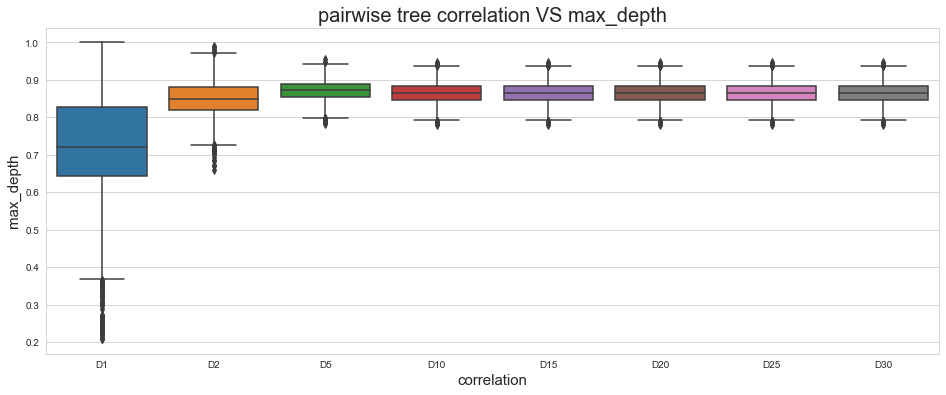

In [27]:
plt.figure(figsize=(16,6))
x_plot = []
y_plot = []

for max_depth in [1, 2, 5, 10, 15, 20, 25, 30]:
    clf = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state = 42)
    clf.fit(X_train, y_train)
    corr = base_model_pair_correlation(clf, X)
    y_plot.append(corr)
    x_plot += [f"D{max_depth}"]*len(corr)

sns.boxplot(y=np.concatenate(y_plot), x=x_plot)

plt.xlabel("correlation", size=15)
plt.ylabel("max_depth", size=15)
plt.title("pairwise tree correlation VS max_depth", size=20)
plt.show()

Опишите ваши наблюдения:

* корреляция в целом растет с ростом _max_feature_, при этом она уже больше 0.8. для классификации рекомендуют ```sqrt(feature_cnt)=sqrt(30)=5.5```.



### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по [медицинским показателям](https://www.kaggle.com/ronitf/heart-disease-uci).

In [28]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [29]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [30]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [31]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##



## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

NameError: name 'voting_hard' is not defined

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [ ]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [ ]:
data = pd.read_csv("churn.csv")
data.head()

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**